### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import warnings
from fbprophet import Prophet
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

### Load data

In [2]:
df = pd.read_csv('household.txt', sep = ";", low_memory=False, infer_datetime_format=True, parse_dates={'Datetime':[0,1]}, index_col=['Datetime'])
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


### Data Preprocessing

In [3]:
# mark all missing values
df.replace('?', np.nan, inplace=True)
# make dataset numeric
df = df.astype('float32')

In [4]:
# df = df.fillna(df.mean())
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)

In [11]:
resampled_df = df.resample('D').sum()
resampled_df = resampled_df.reset_index()

### Question 12

In [12]:
corr, p = pearsonr(resampled_df['Global_active_power'], resampled_df['Global_reactive_power'])
print(f'pearson coreelation coefficient is: {round(corr, 2)}')

pearson coreelation coefficient is: 0.04


### Question 13

In [13]:
corr, p = pearsonr(resampled_df['Voltage'], resampled_df['Global_intensity'])
print(f'pearson coreelation coefficient is: {round(corr, 2)}')

pearson coreelation coefficient is: 0.05


### Univariate Time series  Forcasting

In [14]:
data = resampled_df[['Datetime', 'Global_active_power']]
data = data.rename(columns={'Datetime': 'ds',
                        'Global_active_power': 'y'})

data.head(5)

,ds,y
0,2006-12-16,1209.176025
1,2006-12-17,3390.459961
2,2006-12-18,2203.825928
3,2006-12-19,1666.193970
4,2006-12-20,2225.748047


### Split Data 

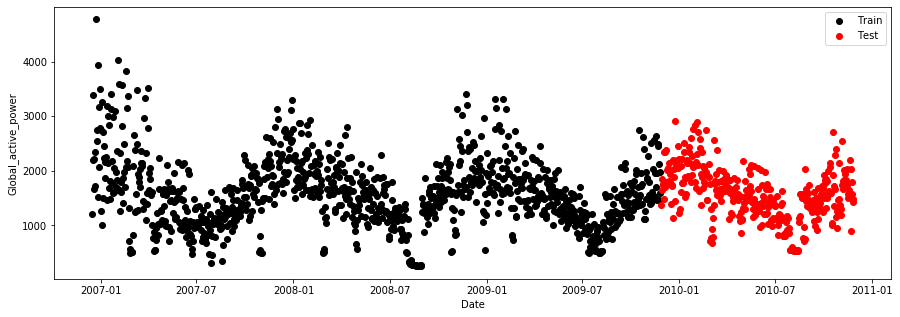

In [15]:
n_tests = 365
# train set
df_train = data[:-n_tests]

# test set
df_test = data[-n_tests:]

# visualize
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_train['ds'], df_train['y'], linestyle='None', marker='o', color='black', label='Train')
ax.plot(df_test['ds'], df_test['y'], linestyle='None', marker='o', color='red', label='Test')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Global_active_power');

In [16]:
model = Prophet(weekly_seasonality=True, daily_seasonality=True)

In [17]:
# fit the model  on training data
model.fit(df_train);

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
C:\Users\samue\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [18]:
# predict
forecast = model.predict(df_test)
forecast[['ds', 'yhat']].tail()

,ds,yhat
360,2010-11-22,2035.604300
361,2010-11-23,2177.749435
362,2010-11-24,2188.782964
363,2010-11-25,2021.435027
364,2010-11-26,2151.718525


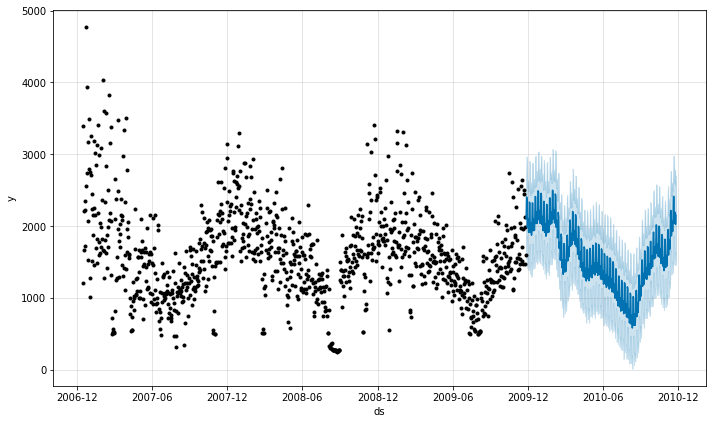

In [19]:
# visualize forcast
model.plot(forecast,
              uncertainty=True);

### Question 14

In [20]:
y_true = np.array(df_test['y'])
y_forecast = np.array(forecast['yhat'])
mape = np.mean(np.abs((y_true - y_forecast) / y_true)) * 100
print('The MAPE error is:', round(mape, 2))

The MAPE error is: 20.86


### Question 15

In [21]:
rmse = np.sqrt(mean_squared_error(y_true, y_forecast))
round(rmse,2)

374.89

### Question16. 
**Answer: September**

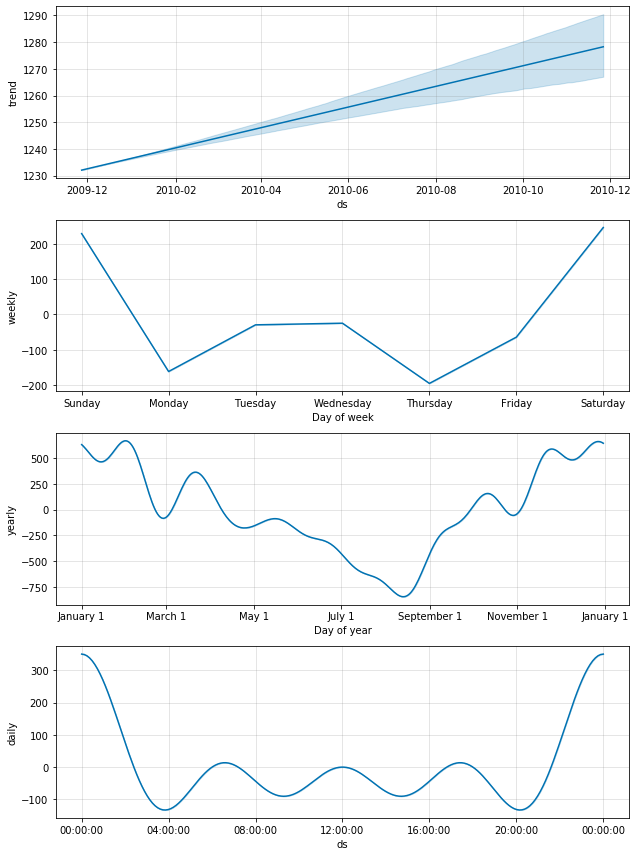

In [22]:
model.plot_components(forecast);

# Multivariate Time Focasting

In [23]:
# add new varibles to previous data

data['add1'] = resampled_df['Global_reactive_power']
data['add2'] = resampled_df['Voltage']
data['add3'] = resampled_df['Global_intensity']
data['add4'] = resampled_df['Sub_metering_1']
data['add5'] = resampled_df['Sub_metering_2']
data['add6'] = resampled_df['Sub_metering_3']

In [24]:
data.head()

,ds,y,add1,add2,add3,add4,add5,add6
0,2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
1,2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2,2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
3,2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
4,2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


### Split data

In [25]:
n_tests = 365
df_train = data[:-n_tests]
df_test = data[-n_tests:]

### Fit model

In [26]:
new_model = Prophet(weekly_seasonality=True, daily_seasonality=True)
new_model.add_regressor('add1')
new_model.add_regressor('add2')
new_model.add_regressor('add3')
new_model.add_regressor('add4')
new_model.add_regressor('add5')
new_model.add_regressor('add6')
new_model.fit(df_train);

C:\Users\samue\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


### Make and visualize forcast

In [27]:
forecast = new_model.predict(df_test)

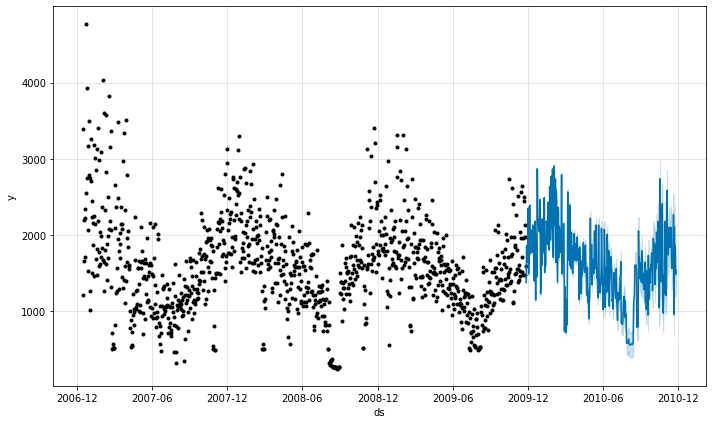

In [28]:
new_model.plot(forecast,
              uncertainty=True);

### Question 17

In [29]:
y_true = np.array(df_test['y'])
y_forecast = np.array(forecast['yhat'])
mape = np.mean(np.abs((y_true - y_forecast) / y_true)) * 100
print('The MAPE error is:', round(mape, 2))

The MAPE error is: 2.39


### Question 18

In [30]:
rmse = np.sqrt(mean_squared_error(y_true, y_forecast))
round(rmse,2)

35.99

### Question 19
**Answer: Tuesday**

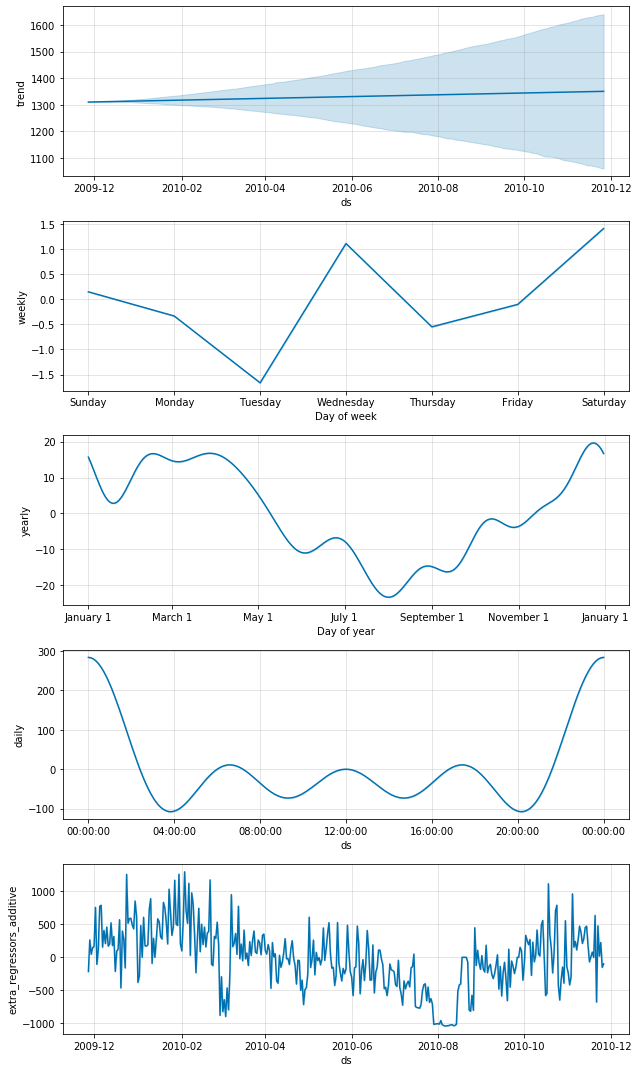

In [31]:
new_model.plot_components(forecast);